# Lab 6 - Part of Speech Tagging
SIDDHI SUBHEDAR
PRN: 1262240621

### Imports

In [11]:
import nltk
from nltk.corpus import treebank
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag, UnigramTagger, hmm
from nltk.metrics import accuracy
import tensorflow as tf
from nltk.metrics import accuracy
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
import numpy as np

# Download required NLTK resources
nltk.download("treebank")
nltk.download("punkt")
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

### Get Penn Treebank dataset

In [ ]:
# Load dataset (Penn Treebank sample)
dataset = treebank.tagged_sents()  # List of sentences with tagged words

# Split data into train and test sets (80-20 split)
split_ratio = int(0.8 * len(dataset))
train_data = dataset[:split_ratio]
test_data = dataset[split_ratio:]

# Extract only words from test data
test_sentences = [[word for word, tag in sent] for sent in test_data]


## Rule Based Tagging

### Pos_tag

In [2]:

# Rule-based PoS tagging using NLTK's pos_tag()
predicted_tags = [pos_tag(sent) for sent in test_sentences]

# Convert predicted tags to match the test data format
predicted_tags_cleaned = [[(word, tag) for word, tag in sent] for sent in predicted_tags]

gold_tags = [[(word, tag) for word, tag in sent] for sent in test_data]

# Compute accuracy
correct = sum(1 for pred, gold in zip(predicted_tags_cleaned, gold_tags) if pred == gold)
accuracy_score = correct / len(test_data)
print(f"Rule-Based PoS Tagging Accuracy: {accuracy_score * 100:.2f}%")


[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


Rule-Based PoS Tagging Accuracy: 10.22%


### Unigram Tagger

In [6]:
# Implement Unigram Tagger
unigram_tagger = UnigramTagger(train_data)
predicted_unigram = [unigram_tagger.tag(sent) for sent in test_sentences]

# Compute accuracy for UnigramTagger
correct_unigram = sum(1 for pred, gold in zip(predicted_unigram, gold_tags) if pred == gold)
accuracy_unigram = correct_unigram / len(test_data)
print(f"Rule-Based PoS Tagging Accuracy (UnigramTagger): {accuracy_unigram * 100:.2f}%")


Rule-Based PoS Tagging Accuracy (UnigramTagger): 7.28%


## Hidden Markov Model Tagger

In [8]:
# Implement HMM Tagger
hmm_trainer = hmm.HiddenMarkovModelTrainer()
hmm_tagger = hmm_trainer.train(train_data)
predicted_hmm = [hmm_tagger.tag(sent) for sent in test_sentences]

# Compute accuracy for HMM Tagger
correct_hmm = sum(1 for pred, gold in zip(predicted_hmm, gold_tags) if pred == gold)
accuracy_hmm = correct_hmm / len(test_data)
print(f"PoS Tagging Accuracy (HMM Tagger): {accuracy_hmm * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/nltk/tag/hmm.py:333: RuntimeWarning: overflow encountered in cast
  X[i, j] = self._transitions[si].logprob(self._states[j])
/usr/local/lib/python3.11/dist-packages/nltk/tag/hmm.py:335: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])
/usr/local/lib/python3.11/dist-packages/nltk/tag/hmm.py:331: RuntimeWarning: overflow encountered in cast
  P[i] = self._priors.logprob(si)
/usr/local/lib/python3.11/dist-packages/nltk/tag/hmm.py:363: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])


PoS Tagging Accuracy (HMM Tagger): 9.58%


## Deep Learning Based Tagger

### Bidirectional LSTM

In [ ]:
# Split data into train and test sets
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Extract words and tags
words = list(set(word for sent in dataset for word, tag in sent))
tags = list(set(tag for sent in dataset for word, tag in sent))

# Create word-to-index and tag-to-index mappings
word2idx = {word: i + 1 for i, word in enumerate(words)}
tag2idx = {tag: i for i, tag in enumerate(tags)}
idx2tag = {i: tag for tag, i in tag2idx.items()}

# Convert sentences and tags to sequences
X_train = [[word2idx[word] for word, tag in sent] for sent in train_data]
y_train = [[tag2idx[tag] for word, tag in sent] for sent in train_data]
X_test = [[word2idx.get(word, 0) for word, tag in sent] for sent in test_data]
y_test = [[tag2idx[tag] for word, tag in sent] for sent in test_data]

# Pad sequences
max_len = max(len(sent) for sent in X_train)
X_train = pad_sequences(X_train, maxlen=max_len, padding="post")
y_train = pad_sequences(y_train, maxlen=max_len, padding="post")
X_test = pad_sequences(X_test, maxlen=max_len, padding="post")
y_test = pad_sequences(y_test, maxlen=max_len, padding="post")

# One-hot encode labels
y_train = [to_categorical(sent, num_classes=len(tags)) for sent in y_train]
y_test = [to_categorical(sent, num_classes=len(tags)) for sent in y_test]

# Build BiLSTM Model
model = Sequential([
    Embedding(input_dim=len(words) + 1, output_dim=64, input_length=max_len),
    Bidirectional(LSTM(units=100, return_sequences=True)),
    Dense(len(tags), activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train Model
model.fit(X_train, np.array(y_train), batch_size=32, epochs=5, validation_data=(X_test, np.array(y_test)))

# Evaluate Accuracy
test_loss, test_acc = model.evaluate(X_test, np.array(y_test))
print(f"PoS Tagging Accuracy (BiLSTM): {test_acc * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 56s 500ms/step - accuracy: 0.8630 - loss: 0.8766 - val_accuracy: 0.9208 - val_loss: 0.2761
Epoch 2/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 81s 497ms/step - accuracy: 0.9319 - loss: 0.2559 - val_accuracy: 0.9508 - val_loss: 0.2016
Epoch 3/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 81s 482ms/step - accuracy: 0.9548 - loss: 0.1760 - val_accuracy: 0.9689 - val_loss: 0.1244
Epoch 4/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 486ms/step - accuracy: 0.9741 - loss: 0.1064 - val_accuracy: 0.9846 - val_loss: 0.0744
Epoch 5/5
96/98 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9879 - loss: 0.0614

## Load Twitter dataset

In [13]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("cosmos98/twitter-and-reddit-sentimental-analysis-dataset")

print("Path to dataset files:", path)

100%|██████████| 10.0M/10.0M [00:00<00:00, 49.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/cosmos98/twitter-and-reddit-sentimental-analysis-dataset/versions/1


In [18]:
import pandas as pd
import os

data = pd.read_csv(os.path.join(path,"Twitter_Data.csv"), encoding="ISO-8859-1")
data.head()

,clean_text,category
0,when modi promised âminimum government maxim...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [19]:
# drop rows where category is 0 (neutral)

df = data[data['category']!=0]
df['category'].unique()

array([-1.,  1., nan])

In [20]:
# remove nan

df = df.dropna()
df.isna().sum()

,0
clean_text,0
category,0


In [23]:
df.shape

(107758, 2)

### balance classes

In [38]:
count=15000

import pandas as pd

# Get the counts of each class
class_counts = df['category'].value_counts()

sampled_dfs = {}

for category in df['category'].unique():
    sampled_dfs[category] = df[df['category'] == category].sample(min(count, class_counts[category]), random_state=42)

new_df = pd.concat(sampled_dfs.values(), ignore_index=True)

print(new_df.shape)
print(new_df.head())


(30000, 2)
                                          clean_text  category
0  desperately waiting watch the not movie review...      -1.0
1  madam kanpur and akbarpur seat will loose cand...      -1.0
2  everything that happened under nehru gandhi du...      -1.0
3  funny that such renowned writer doesnt know th...      -1.0
4  and all this possible only due the efforts inv...      -1.0


In [39]:
new_df['category'].unique()

array([-1.,  1.])

### using Bi-directional LSTM model trained above to tag Part of Speech in clean_text

In [40]:

# Tokenize clean text and convert words to indices
X_clean = [[word2idx.get(word, 0) for word in clean_text.split()] for clean_text in new_df['clean_text']]

# Pad sequences
X_clean = pad_sequences(X_clean, maxlen=max_len, padding="post")

# Predict PoS tags using the BiLSTM model
y_pred = model.predict(X_clean)

# Convert the predicted one-hot encoded labels back to tag indices
y_pred_tags = np.argmax(y_pred, axis=-1)

# Map predicted tag indices to actual tags
predicted_tags = [[idx2tag[tag] for tag in sent] for sent in y_pred_tags]

# Display predicted PoS tags for the first few sentences
for i in range(5):  # Displaying first 5 sentences
    print(f"Text: {new_df['clean_text'][i]}")
    print(f"Predicted PoS Tags: {predicted_tags[i]}")
    print()

938/938 ━━━━━━━━━━━━━━━━━━━━ 117s 124ms/step
Text: desperately waiting watch the not movie review upcoming narendra modi please the first day release 
Predicted PoS Tags: ['NNP', 'PRP', 'NN', 'DT', 'RB', 'NN', 'NN', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 'PRP', 

In [41]:
# Feature extraction from predicted PoS tags (using one-hot encoding or frequency count)
from sklearn.preprocessing import LabelEncoder

# Flatten the predicted tags to encode each tag as a feature
flattened_tags = [tag for sublist in predicted_tags for tag in sublist]
tag_encoder = LabelEncoder()
tag_encoded = tag_encoder.fit_transform(flattened_tags)

# Reshape to get features for each sentence (by aggregating tags for the sentence)
tag_features = [tag_encoded[i:i+len(sent)] for i, sent in enumerate(predicted_tags)]

# Convert to the format you want to use for model training
tag_features = np.array([np.array(sent) for sent in tag_features])

# Label encoding for the target (classification labels: 1 or -1)
y_class = new_df['category'].values  # Assuming 'category' is your target

# Train-test split for the classification model
from sklearn.model_selection import train_test_split
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(tag_features, y_class, test_size=0.2, random_state=42)

tag_features

array([[12, 15, 11, ..., 15, 15, 15],
       [15, 11,  6, ..., 15, 15, 15],
       [11,  6, 17, ..., 15, 15, 15],
       ...,
       [15, 15, 15, ..., 15, 15, 15],
       [15, 15, 15, ..., 15, 15, 15],
       [15, 15, 15, ..., 15, 15, 15]])

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Train a Random Forest classifier on the PoS tag features
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train_class, y_train_class)

# Predict on the test set
y_pred_class = classifier.predict(X_test_class)

# Evaluate the classification model
accuracy = accuracy_score(y_test_class, y_pred_class)
print(f"Classification Accuracy: {accuracy * 100:.2f}%")

Classification Accuracy: 52.07%


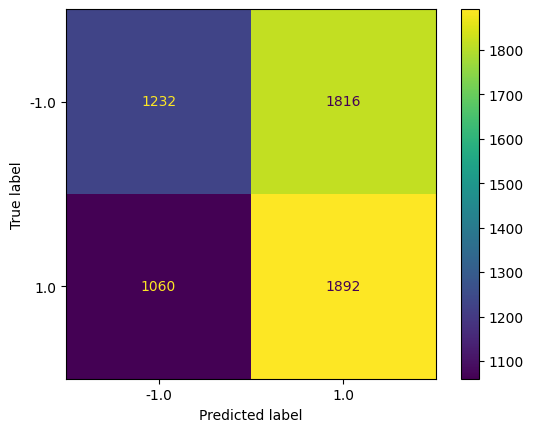

In [43]:
from sklearn.metrics import precision_score, recall_score, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_class, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()